In [1]:
first_term = "buitenlandsche"

In [2]:
import re, os, glob, pandas as pd
import editdistance
import sys
import dask.dataframe as dd

In [4]:
## Import token totals
os.chdir("C://Users//Ruben//Documents//GitHub//TheForeign//SCC//output-data")
token_totals = pd.read_csv('tokens_year.csv')

## Import Master DF
os.chdir("C://Users//Ruben//Documents//Scriptie//Data//bigrams//output")
df = dd.read_csv('total-bigrams.csv', dtype='str')

##
os.chdir("C://Users//Ruben//Documents//Scriptie//Data//unigrams//output//years")
df_unigrams = pd.read_csv('total-unigrams.csv')

## Define ED function
def GetCloseED(master_df, search_term, len_restr):
    output_list = list()
    
    subset_df = master_df[master_df.ngram.str[0] == search_term[0]]
    
    for word in list(subset_df.ngram):
        ed = editdistance.eval(search_term, word)
        if ed < 3:
            output_list.append(word)
    if len_restr == "yes":
        output_list = [e for e in output_list if len(e) == len(search_term)]
    return output_list

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
list_alternatives = GetCloseED(df_unigrams, first_term, 'yes')

In [6]:
subset = df[df['ngram'].str.split().str[0].isin(list_alternatives)].compute()

In [121]:
subset['ngram'] = subset['ngram'].str.split().str[1]
subset = subset.reset_index(drop=True)
subset['count'] = subset['count'].astype(float)
subset = subset.groupby(['ngram','year']).agg('sum')
subset = subset.stack().reset_index().drop('level_2', axis = 1)
subset.columns = ['ngram', 'year', 'count']
subset = subset.dropna()
subset = subset.pivot(index='ngram', columns='year', values='count')
subset = subset.fillna(0)
subset.columns = subset.columns.astype(str)

In [122]:
list_sums = dict()

for i in list(subset.columns):
    tmp = sum(subset[i].astype(float))
    tmp = {i:tmp}
    list_sums.update(tmp)
    
df_sums = pd.DataFrame(list(list_sums.keys()))
df_sums['counts'] = list(list_sums.values())
df_sums.columns = ['years', 'counts']

In [123]:
token_totals['ngram'] = ''

for i in range(0,len(token_totals)):
    year = token_totals.year[i]
    matching_df = df_sums[df_sums.years == str(year)]
    
    if len(matching_df) == 0:
        count = 0
    else:
        count = matching_df.iloc[0,1]
    
    token_totals.ngram[i] = count
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [124]:
token_totals['ngram_rel'] = token_totals['ngram'] / token_totals['tokens'] * 100

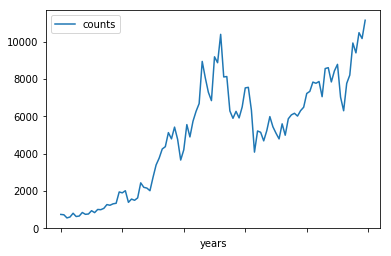

In [125]:
df_sums['counts'] = df_sums['counts'].astype(int)
plot = df_sums.plot.line(x='years',y='counts')

In [126]:
os.chdir("C://Users//Ruben//Documents//GitHub//TheForeign//SCC//output-data")

In [127]:
filename = "bigrams_" + first_term + ".csv"
subset.to_csv(filename, index=True)